In [3]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('/content/monthly_milk_production.csv', index_col='Date', parse_dates=True)
df.index.freq='MS'

In [6]:
df.tail()

,Production
Date,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


<Axes: xlabel='Date'>

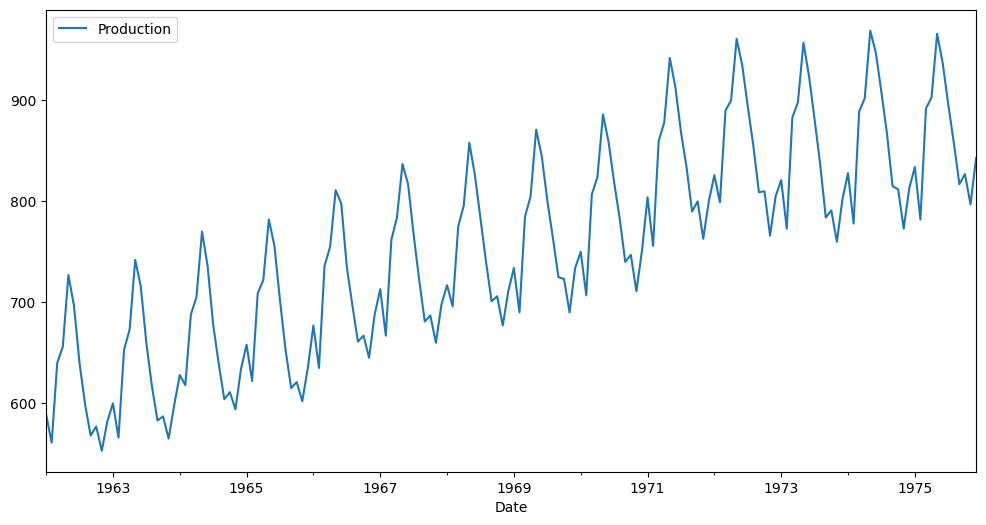

In [7]:
df.plot(figsize=(12,6))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

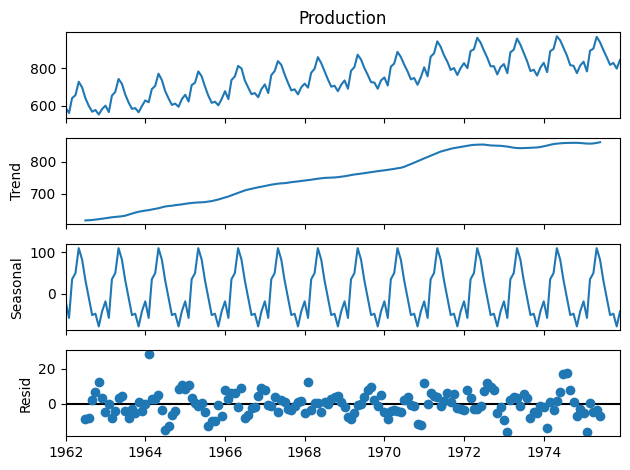

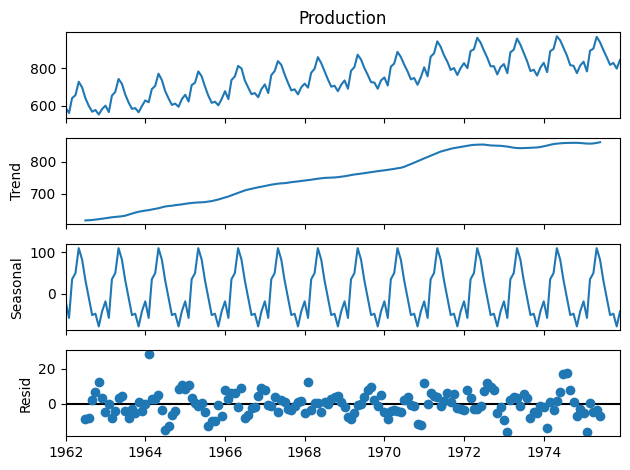

In [12]:
results=seasonal_decompose(df['Production'])
results.plot()

In [13]:
len(df)

168

In [14]:
train=df.iloc[:156]
test=df.iloc[156:]

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [16]:
df.head(), df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [18]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [19]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
#define_generator
n_input=3
n_features=1
generator=TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [27]:
X,y=generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Prdeict this y: \n{y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Prdeict this y: 
[[0.24759615]]


In [28]:
X.shape

(1, 3, 1)

In [30]:
#We have to do the same thing, but now for 12 months
n_input=12
generator=TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [32]:
model=Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
#fit model
model.fit(generator, epochs=50)

Epoch 1/50
144/144 [==============================] - 4s 11ms/step - loss: 0.0522
Epoch 2/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0199
Epoch 3/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0170
Epoch 4/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0114
Epoch 5/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0100
Epoch 6/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0065
Epoch 7/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0095
Epoch 8/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 9/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 10/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0044
Epoch 11/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 12/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0035
Epoch 13/50
144/144 [==

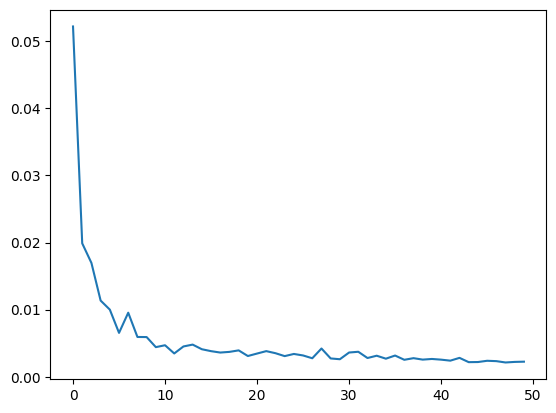

In [35]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [36]:
last_train_batch=scaled_train[-12:]

In [37]:
last_train_batch=last_train_batch.reshape((1,n_input, n_features))

In [38]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 221ms/step


array([[0.6137885]], dtype=float32)

In [39]:
scaled_test[0]

array([0.67548077])

In [40]:
test_predictions=[]

first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

  #get the prdiction value for the first batch
  current_pred=model.predict(current_batch)[0]

  #append the prediction into the carry
  test_predictions.append(current_pred)

  #use the prediction to update the batch and remove the first value
  current_batch=np.append(current_batch[:, 1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 30ms/step


In [41]:
test_predictions

[array([0.6137885], dtype=float32),
 array([0.58585495], dtype=float32),
 array([0.749698], dtype=float32),
 array([0.81747687], dtype=float32),
 array([0.9283694], dtype=float32),
 array([0.90688103], dtype=float32),
 array([0.8361587], dtype=float32),
 array([0.7434697], dtype=float32),
 array([0.64510024], dtype=float32),
 array([0.60808563], dtype=float32),
 array([0.55476797], dtype=float32),
 array([0.59233814], dtype=float32)]

In [44]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [45]:
true_predictions=scaler.inverse_transform(test_predictions)

In [46]:
test['Predictions']=true_predictions

<ipython-input-46-37e263692d24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_predictions


<Axes: xlabel='Date'>

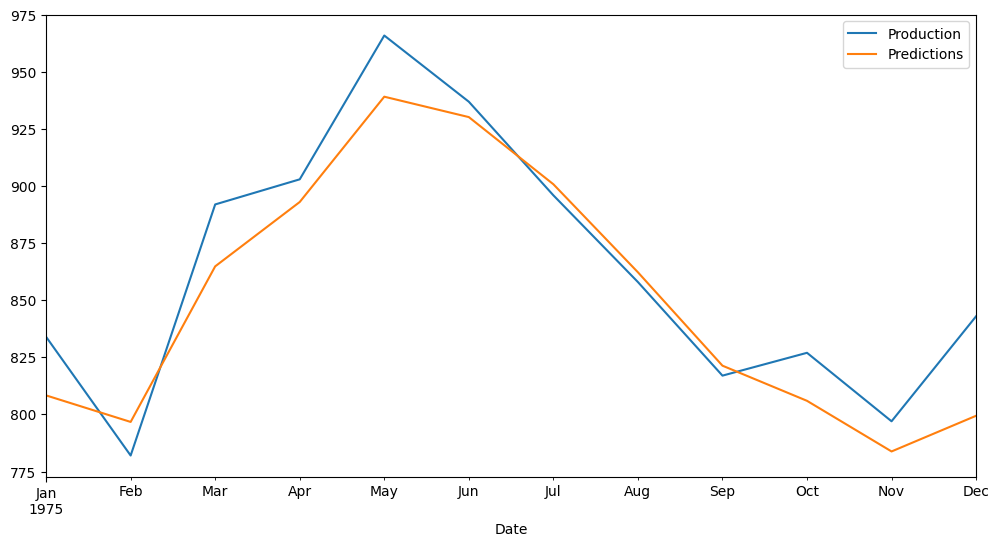

In [47]:
test.plot(figsize=(12,6))

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(rmse)

20.516276290668443
